In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
import scipy.special as sp
import pandas as pd

In [2]:
colors = ["xkcd:dusty blue", "xkcd:dark peach", "xkcd:dark seafoam green", 
          "xkcd:dusty purple","xkcd:watermelon", "xkcd:dusky blue", "xkcd:amber", 
          "xkcd:purplish", "xkcd:dark teal", "xkcd:orange", "xkcd:slate"]

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

In [3]:
def plot_ds(data,m=None,q=None):
    fig = plt.figure(figsize=(16,8))
    minx, maxx = min(data.x1), max(data.x1)
    deltax = .1*(maxx-minx)
    x = np.linspace(minx-deltax,maxx+deltax,1000)
    ax = fig.gca()
    ax.scatter(data[data.t==0].x1, data[data.t==0].x2, s=40, edgecolor='k', alpha=.7)
    ax.scatter(data[data.t==1].x1, data[data.t==1].x2, s=40, edgecolor='k', alpha=.7)
    if m:
        ax.plot(x, m*x+q, lw=2, color=colors[5])
    plt.xlabel('$x_1$', fontsize=12)
    plt.ylabel('$x_2$', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('Dataset', fontsize=12)
    plt.show()

In [228]:
def plot_all(cost_history, m, q, low, high, step, m_star, q_star):
    idx = range(low,high,step)
    ch = cost_history[idx]
    th1 = m[idx]
    th0 = q[idx]
    fig = plt.figure(figsize=(18,6))
    ax = fig.add_subplot(1,2,1)
    minx, maxx, miny, maxy = 0, len(ch), ch.min(), ch.max()
    deltay, deltax = .1*(maxy-miny), .1*(maxx-minx)
    miny, maxy, minx, maxx = miny - deltay, maxy + deltay, minx - deltax, maxx + deltax
    ax.plot(range(len(ch)), ch, alpha=1, color=colors[0], linewidth=2)
    plt.xlabel('iterazioni')
    plt.ylabel('costo')
    plt.xlim(minx,maxx)
    plt.ylim(miny,maxy)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x*step+low)))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    ax = fig.add_subplot(1,2,2)
    minx, maxx, miny, maxy = th0.min(), max(th0.max(),q_star), th1.min(), max(th1.max(),m_star)
    deltay, deltax = .1*(maxy-miny), .1*(maxx-minx)
    miny, maxy = miny - deltay, maxy + deltay
    miny, maxy, minx, maxx = miny - deltay, maxy + deltay, minx - deltax, maxx + deltax
    ax.plot(th0, th1, alpha=1, color=colors[1], linewidth=2, zorder=1)
    ax.scatter(th0[-1],th1[-1], color=colors[5], marker='o', s=40, zorder=2)
    ax.scatter(q_star,m_star, color=colors[7], marker='x', s=80, zorder=3)
    plt.xlabel(r'$q$')
    plt.ylabel(r'$m$')
    plt.xlim(minx,maxx)
    plt.ylim(miny,maxy)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

### Rischio e minimizzazione
Dato un qualunque algoritmo che fornisce per ogni valore di input $x$ una previsione $f(x)$, la qualità delle previsioni fornite dall'algoritmo può essere definita per mezzo di una *funzione di costo* (loss function) $L(x_1, x_2)$, dove $x_1$ è il valore predetto dal modello e $x_2$ è il valore corretto associato a $x$ . Sostanzialmente, il valore della funzione di costo $L(f(x),y)$ misura quindi quanto "costa" (secondo il modello di costo indotto dalla funzione stessa) prevedere, dato $x$, il valore $f(x)$ invece del valore corretto $y$.

Dato che evidentemente il costo è dipendente dalla coppia di valori $x,y$, una valutazione complessiva della qualità delle predizioni dell'algoritmo potrà essere fornita considerando il valore atteso della funzione di costo al variare di $x$ e  $y$, nell'ipotesi di una (densità di) distribuzione di probabilità congiunta di tali valori $p(x,y)$. La distribuzione $p(x,y)$ ci fornisce quindi la probabilità che il prossimo punto su cui effettuare la predizione sia $x$ e che il valore corretto da predire sia $y$. Si noti che non si fa l'ipotesi che due diverse occorrenze di $x$ siano associate allo stesso valore di $y$: non si assume quindi una relazione funzionale, seppure sconosciuta, tra $x$ e $y$, ma solo una relazione in probabilità $p(y\mid x)$. 
Questo permette di considerare la presenza di rumore nelle osservazioni effettuate.

Da quanto detto, indicando con $D_x$ e $D_y$ i domini di definizione di $x$ e $y$, e assunta una distribuzione $p(x,y)$ che fornisce un modello statistico del contesto in cui si intende effettuare le predizioni, la qualità di un algoritmo di previsione che calcola la funzione $f(x)$ sarà data dal *rischio*
$$
\mathcal{R}(f)=\mathbb{E}_p[L(f(x),y)]=\int_{D_x}\int_{D_y} L(f(x),y)p(x,y)dxdy
$$

Il rischio di dice quindi quanto ci aspettiamo che ci costi prevedere $f(x)$, assumendo che:

1. $x$ sia estratto a caso dalla distribuzione marginale
   $$
   p(x)=\int_{D_y} p(x,y)dy
   $$

2. il relativo valore corretto da predire sia estratto a caso dalla distribuzione condizionata 
$$
p(y\mid x)=\frac{p(x,y)}{p(x)}
$$

3. il costo sia rappresentato dalla funzione $L(x_1,x_2)$

##### Esempio

Consideriamo il caso in cui vogliamo effettuare previsioni sulla possibilità di pioggia in giornata, date le condizioni del cielo al mattino, assumendo che le possibili osservazioni siano "sereno" (S), "nuvoloso" (N), "coperto" (C), e che le previsioni siano "pioggia" (T) e "non pioggia" (F). La funzione di costo, sarà allora del tipo $L:\{T,F\}^2\mapsto\mathbb{R}$

La definizione di una particolare funzione di costo è legata alla valutazione delle priorità dell'utente. Nel caso specifico, se si valuta allo stesso modo "sgradevole" uscire con l'ombrello (per una previsione T) senza poi doverlo usare che bagnarsi per la pioggia non avendo preso l'ombrello (per una previsione F) allora la funzione di costo risulta $L_1(x_1,x_2)$, definita dalla tabella seguente

| $x_1$/$x_2$ |  T   |  F   |
| :---------: | :--: | :--: |
|      T      |  0   |  1   |
|      F      |  1   |  0   |

Se invece reputiamo molto più sgradevole bagnarci per non aver preso l'ombrello rispetto a prendere l'ombrello stesso inutilmente, allora la funzione di costo $L_2(x_1,x_2)$, potrà essere definita come

| $x_1$/$x_2$ |  T   |  F   |
| :---------: | :--: | :--: |
|      T      |  0   |  1   |
|      F      |  25   |  0   |

Se facciamo l'ipotesi che la distribuzione congiunta su $\{S,N,C\}\times\{T,F\}$ sia 

| $x$/$y$ |  T   |  F   |
| :-----: | :--: | :--: |
|    S    | .05  |  .2  |
|    N    | .25  | .25  |
|    C    |  .2  | .05  |

e consideriamo due possibili funzioni predittive $f_1(x)$ e $f_2(x)$


| $x$  |   $f_1(x)$         | $f_2(x)$ |
| :--: | :--------------------:         | :------: |
|  S   |    &nbsp; &nbsp; F &nbsp; &nbsp; &nbsp; | &nbsp; &nbsp; F &nbsp; &nbsp; &nbsp;  |
|  N   |    &nbsp; &nbsp; F               | &nbsp; &nbsp; T     |
|  C   |    &nbsp; &nbsp; T               | &nbsp; &nbsp; T     |


possiamo verificare che nel caso in cui la funzione di costo sia $L_1$ allora il rischio nei due casi è  $\mathcal{R}(f_1)=0.65$ e $\mathcal{R}(f_2)=0.4$ per cui $f_2$ è preferibile a $f_1$. Al contrario, se la funzione di costo è $L_2$, allora risulta $\mathcal{R}(f_1)=1.55$ e $\mathcal{R}(f_2)=7.55$, per cui, al contrario, $f_1$ è preferibile a $f_2$.

Come si vede, quindi, la scelta tra $f_1(x)$ e $f_2(x)$ è dipendente dalla funzione di costo adottata e dalla distribuzione $p(x,y)$ che invece è data e, tra l'altro, sconosciuta. Quindi, una diversa distribuzione potrebbe portare a conclusioni diverse anche considerando una stessa funzione di costo: se ad esempio si fa riferimento alla funzione di costo $L_1$, allora la distribuzione congiunta

| $x$/$y$ |  T   |  F   |
| :-----: | :--: | :--: |
|    S    | .05  | .05  |
|    N    | .05  |  .4  |
|    C    | .05  |  .4  |

determina dei valori di rischio $\mathcal{R}(f_1)=0.6$ e $\mathcal{R}(f_2)=0.9$, rendendo ora $f_1$ preferibile a $f_2$.


#### Rischio empirico
Dato che la distribuzione reale $p(x,y)$ è sconosciuta per ipotesi (se così non fosse potremmo sempre effettuare predizioni utilizzando la distribuzione condizionata reale $p(y\mid x)$) il calcolo del rischio reale è impossibile ed è necessario effettuare delle approssimazioni, sulla base dei dati disponibili. In particolare, possiamo applicare il metodo standard di utilizzando la media aritmetica su un campione come stimatore del valore atteso, e considerare il *rischio empirico* (empirical risk) calcolato effettuando l'operazione di media sul campione offerto dai dati disponibili nel training set $X=\{(x_1,y_1),\ldots,(x_n,y_n)\}$

$$
\overline{\mathcal{R}}(f; X)=\overline{L}(f(x), y; X)=\frac{1}{n}\sum_{i=1}^nL(f(x_i),y_i)
$$

La funzione utilizzata per le predizioni sarà allora quella che, nell'insieme di funzioni considerato, minimizza il rischio empirico

$$
f^*=\underset{f\in F}{\mathrm{argmin}}\;\overline{\mathcal{R}}(f;X)
$$

Si noti che, in effetti, il rischio empirico dipende sia dai dati in $X$ che dalla funzione $f$: in questo senso è una funzione rispetto a $X$ e un funzionale rispetto a $f$. La ricerca di $f^*$ comporta quindi una minimizzazione funzionale del rischio empirico. In generale, tale situazione viene semplificata limitando la ricerca all'interno di classi di funzioni definite da coefficienti: in questo modo, il rischio empirico può essere espresso come funzione dei coefficienti della funzione (oltre che di $X$) e la minimizzazione è una normale minimizzazione di funzione. 

Chiaramente, la speranza è che minimizzare il rischio empirico dia risultati simili a quelli che si otterrebbero minimizzando il rischio reale. Ciò dipende, in generale, da quattro fattori:

- La dimensione del training set $X$. Al crescere della quantità di dati, $\overline{\mathcal{R}}(f; X)$ tende a $\mathcal{R}(f)$ per ogni funzione $f$
- La distribuzione reale $p(x,y)$. Maggiore è la sua complessità, maggiore è la quantità di dati necessari per averne una buona approssimazione.
- La funzione di costo $L$, che può creare problemi se assegna costi molto elevati in situazioni particolari e poco probabili
- L'insieme $F$ delle funzioni considerate. Se la sua dimensione è elevata, e le funzioni hanno una struttura complessa, una maggior quantità di dati risulta necessaria per avere una buona approssimazione.
Al tempo stesso, considerare un insieme piccolo di funzioni semplici rende sì la minimizzazione del rischio implicito su $F$ una buona approssimazione del minimo rischio reale su $F$ stesso, ma al tempo stesso comporta che tale minimo possa essere molto peggiore di quello ottenibile considerando classi più ampie di funzioni.

### Minimizzazione della funzione di rischio

In generale, l'insieme $F$ delle funzioni è definito in modo parametrico $F=\{f(x;\theta)\}$ dove $\theta\in D_\theta$ è un coefficiente (tipicamente multidimensionale) che determina, all'interno della classe $F$ (definita tipicamente in termini ''strutturali'') la particolare funzione utilizzata. Un esempio tipico è offerto dalla *regressione lineare*, in cui si vuole prevedere il valore di un attributo $y$ con dominio $R$ sulla base dei valori di altri $m$ attributi $x_1,\ldots, x_m$ (che assumiamo per semplicità in $R$ anch'essi): nella regressione lineare, l'insieme delle possibili funzioni $f:R^m\mapsto R$ è limitato alle sole funzioni lineari $f_\mathbf{w}(x)=w_0+w_1x_1+\ldots+w_mx_m$, e il parametro $\theta$ corrisponde al vettore $\mathbf{w}=(w_0,\ldots,w_m)$ dei coefficienti.

In questo caso, il rischio empirico, fissata la famiglia $F$ di funzioni, può essere ora inteso come funzione di $\theta$
$$
\overline{\mathcal{R}}(\theta; X)=\overline{L}(f(x;\theta), y; X)=\frac{1}{n}\sum_{i=1}^nL(f(x_i;\theta),y_i)\hspace{2cm}f\in F
$$
e la minimizzazione del rischio empirico può essere effettuata rispetto a $\theta$
$$
\theta^*=\underset{\theta\in D_\theta}{\mathrm{argmin}}\;\overline{\mathcal{R}}(\theta;X)
$$
da cui deriva la funzione ottima (nella famiglia $F$) $f^*=f(x;\theta^*)$

la minimizzazione della funzione di rischio avrà luogo nel dominio di definizione $D_\theta$ di $\theta$, e potrà essere effettuata in modi diversi, in dipendenza della situazione e di considerazioni di efficienza di calcolo e di qualità delle soluzioni derivate.

#### Ricerca analitica dell'ottimo
Se il problema si pone in termini di minimizzazione *senza vincoli*, e quindi all'interno di $R^m$, un primo approccio è quello standard dell'analisi di funzioni, consistente nella ricerca di valori $\overline\theta$ di $\theta$ per i quali si annullano tutte le derivate parziali $\frac{\partial \overline{\mathcal{R}}(\theta; X)}{\partial \theta_i}$, tale cioè che, se indichiamo con $m$ la dimensione (numero delle componenti) di $\theta$, il sistema su $m$ incognite definito dalle $m$ equazioni 
$$
\frac{\partial \overline{\mathcal{R}}(\theta; X)}{\partial \theta_i}\Bigr|_{\theta=\overline\theta}=0\hspace{2cm} i=1,\ldots,m
$$
risulta soddisfatto. La soluzione analitica di questo sistema risulta tipicamente ardua o impossibile, per cui vengono spesso adottate tecniche di tipo numerico.

##### Gradient descent

La discesa del gradiente (*gradient descent*) è una delle tecniche di ottimizzazione più popolari, in particolare nel settore del Machine Learning e delle Reti Neurali. La tecnica consiste nel minimizzare una funzione obiettivo $J(\theta)$ definita sui parametri $\theta\in\mathbb{R}^d$ del modello mediante aggiornamenti successivi del valore di $\theta$ (a partire da un valore iniziale $\theta^{(0)}$) nella direzione opposta a quella del valore attuale del gradiente $J'(\theta)=\nabla J(\theta)$. Si ricorda, a tale proposito, che, data una funzione $f(x_1,x_2,\ldots,x_d)$, il gradiente $\nabla f$ di $f$ è il vettore $d$-dimensionale delle derivate di $f$ rispetto alle variabili $x_1,\ldots, x_d$: il vettore cioè tale che $[\nabla f]_i=\frac{\partial f}{\partial x_i}$. Un parametro $\eta$, detto *learning rate* determina la scala degli aggiornamenti effettuati, e quindi la dimensione dei passi effettuati nella direzione di un minimo locale.

Possiamo interpretare la tecnica come il muoversi sulla superficie della funzione $J(\theta)$ seguendo sempre la direzione di massima pendenza verso il basso, fino a raggiungere un punto da cui è impossibile scendere ulteriormente.

##### Varianti di discesa del gradiente
In molti casi, e sempre nell'ambito del ML, la funzione obiettivo corrisponde all'applicazione di una funzione di costo (*loss function*), predefinita e dipendente dal modello adottato, su un insieme dato di elementi di un dataset $X=(x_1,\ldots, x_n)$ (che nel caso di apprendimento supervisionato è un insieme di coppie $X=((x_1,t_1),\ldots,(x_n,t_n))$): rappresentiamo questa situazione con $J(\theta; X)$. Questo corrisponde all'approssimazione del *rischio* 

$$
\mathcal{R}(\theta)=\int J(\theta,x)p(x)dx=E_{p}[\theta]
$$

In generale, la funzione di costo è definita in modo additivo rispetto agli elementi di $X$ (il costo relativo all'insieme $X$ è pari alla somma dei costi relativi ai suoi elementi), per cui il valore risulta $J(\theta;X)=\sum_{i=1}^nJ(\theta;x_i)$, o preferibilmente, per evitare una eccessiva dipendenza dal numero di elementi, come media 
$$J(\theta;X)=\frac{1}{n}\sum_{i=1}^nJ(\theta;x_i)$$ 
Si noti che, per le proprietà dell'operazione di derivazione, da questa ipotesi deriva l'additività anche del gradiente, per cui 
$$J'(\theta; X)=\sum_{i=1}^nJ'(\theta;x_i)$$ o $$J'(\theta;X)=\frac{1}{n}\sum_{i=1}^nJ'(\theta;x_i)$$

Possiamo allora identificare tre varianti del metodo, che differiscono tra loro per la quantità di elementi di $X$ utilizzati, ad ogni passo, per calcolare il gradiente della funzione obiettivo. Una quantità maggiore di dati utilizzati aumenta l'accuratezza dell'aggiornamento, ma anche il tempo necessario per effettuare l'aggiornamento stesso (in particolare, per valutare il gradiente per il valore attuale di $\theta$).

###### Batch gradient descent

In questo caso, il gradiente è valutato, ogni volta, considerando tutti gli elementi nel training set $X$. Quindi si ha che al passo $k$-esimo viene eseguito l'aggiornamento

$$
\theta^{(k+1)}=\theta^{(k)}-\eta\sum_{i=1}^nJ'(\theta^{(k)};x_i)
$$

 o anche, per i singoli coefficienti

$$
\theta_j^{(k+1)}=\theta_j^{(k)}-\eta\sum_{i=1}^n\frac{\partial J(\theta;x_i)}{\partial\theta_j}\Bigr\vert_{\small\theta=\theta^{(k)}}
$$

Dato che si richiede quindi, ad ogni iterazione, la valutazione del gradiente (con il valore attuale $\theta^{(k)}$ di tutti i coefficienti) su tutti gli elementi di $X$, questa soluzione tende ad essere molto lenta, soprattutto in presenza di dataset di dimensioni molto estese, come nel caso di reti neurali complesse e deep learning. Inoltre, l'approccio diventa del tutto impraticabile se il dataset è talmente esteso da non entrare neanche in memoria.

In termini di codice, il metodo batch gradient descent si presenta come:

```python
for i in range(n_epochs):
    g = 0
    for k in range(dataset_size):
        g = g+evaluate_gradient(loss_function, theta, X[k])
    theta = theta-eta*g
```
Il ciclo viene eseguito un numero di volte pari al numero di epoche, dove per *epoca* si intende una iterazione su tutti gli
elementi di $X$. Di conseguenza, la valutazione di $\theta$ viene aggiornata un numero di volte pari al numero di epoche. Il
metodo batch gradient descent converge certamente al minimo globale se la funzione $J(\theta)$ è convessa, mentre altrimenti
converge a un minimo locale.



##### Esempio
Applichiamo le considerazioni a un semplice problema di classificazione su un dataset bidimensionale, riportato graficamente di seguito.

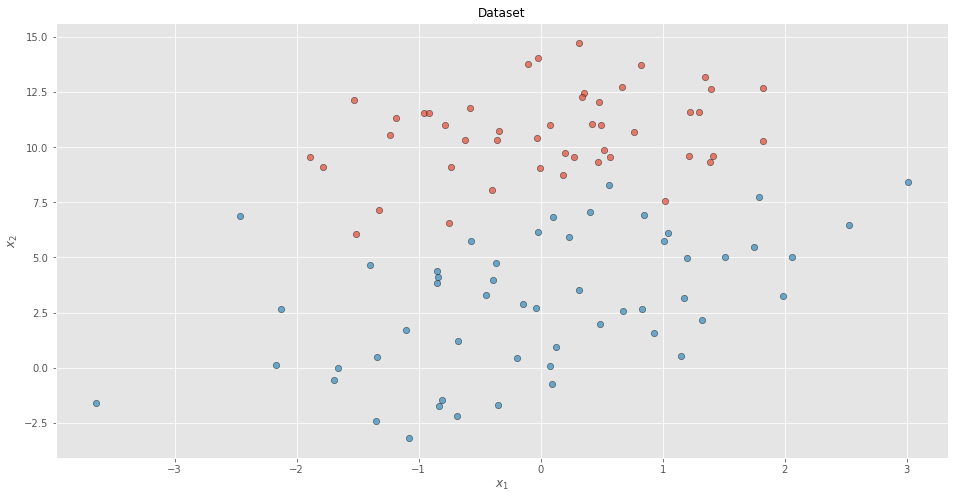

In [5]:
data = pd.read_csv("../dataset/testSet.txt", delim_whitespace=True, header=None, names=['x1','x2','t'])
plot_ds(data)

In [6]:
n = len(data)
nfeatures = len(data.columns)-1

X = np.array(data[['x1','x2']])
t = np.array(data['t']).reshape(-1,1)
X = np.column_stack((np.ones(n), X))


Il metodo considerato per la classificazione è la *logistic regression*, che determina un iperpiano (retta, in questo caso) di separazione minimizzando rispetto al vettore $\theta$ dei coefficienti dell'equazione dell'iperpiano (3 in questo caso) il rischio empirico sul dataset associato alla funzione di costo *cross-entropy*, per la quale il costo associato a un singolo elemento $x=(x_1,\ldots,x_d)$ è

$$ J(\theta, x)=-\left(t\log y + (1-t)\log (1-y)\right) $$
dove $t$ è il valore *target* è il valore $0/1$ della classe dell'elemento e $y\in (0,1)$ è il valore predetto dal modello, definito come 
$$
y = \sigma(x) = \frac{1}{1+e^{-\sum_{i=1}^d\theta_ix_i+\theta_0}}
$$

In [7]:
def sigma(theta, X):
    return sp.expit(np.dot(X, theta))

Il rischio empirico associato all'intero dataset può essere allora definito come la corrispondente media
$$
J(\theta, X)=\frac{1}{n}\sum_{i=1}^n \left(t_i\log \sigma(x_i) -(1-t_i)\log (1-\sigma(x_i))\right)
$$

In [8]:
def approx_zero(v):
    eps = 1e-50
    v[v<eps]=eps
    return v

def cost(theta, X, t):
    eps = 1e-50
    v = sigma(theta,X)
    v[v<eps]=eps
    term1 = np.dot(np.log(v).T,t)
    v = 1.0 - sigma(theta,X)
    v[v<eps]=eps
    term2 = np.dot(np.log(v).T,1-t)
    return ((-term1 - term2) / len(X))[0]

Il gradiente della funzione di costo risulta allora pari a

\begin{align*}
\frac{\partial J(\theta,x)}{\partial\theta_i}&=-(t-\sigma(x))x_i\hspace{1cm}i=1,\ldots,d\\
\frac{\partial J(\theta,x)}{\partial\theta_0}&=-(t-\sigma(x))
\end{align*}

e il corrispondente gradiente del rischio empirico è dato da 
\begin{align*}
\frac{\partial J(\theta,X)}{\partial\theta_i}&=-\frac{1}{n}\sum_{j=1}^n (t_j-\sigma(x_j))x_{ji}\hspace{1cm}i=1,\ldots,d\\
\frac{\partial J(\theta,X)}{\partial\theta_0}&=-\frac{1}{n}\sum_{i=1}^n(t_j-\sigma(x_j))
\end{align*}

In [9]:
def gradient(theta, X, t):
    return -np.dot(X.T, (t-sigma(theta, X))) / len(X)

Per quanto detto, una iterazione di BGD corrisponde agli aggiornamenti
\begin{align*}
\theta_j^{(k+1)}&=\theta_j^{(k)}-\eta\frac{\partial J(\theta,X)}{\partial\theta_j}{\LARGE\vert}_{\small\theta=\theta^{(k)}}=\theta_j^{(k)}+\frac{\eta}{n}\sum_{i=1}^n (t_i-\sigma(x_i))x_{ij}\hspace{1cm}j=1,\ldots,d\\
\theta_0^{(k+1)}&=\theta_0^{(k)}-\eta\frac{\partial J(\theta,X)}{\partial\theta_0}{\LARGE\vert}_{\small\theta=\theta^{(k)}}=\theta_0^{(k)}+\frac{\eta}{n}\sum_{i=1}^n(t_i-\sigma(x_i))
\end{align*}

In [10]:
def batch_gd(X, t, eta = 0.1, epochs = 10000):
    theta = np.zeros(nfeatures+1).reshape(-1,1)
    theta_history = []
    cost_history = []
    for k in range(epochs):             
        theta = theta - eta * gradient(theta,X,t)
        theta_history.append(theta)
        cost_history.append(cost(theta, X, t))
    theta_history = np.array(theta_history).reshape(-1,3)
    cost_history = np.array(cost_history).reshape(-1,1)
    m = -theta_history[:,1]/theta_history[:,2]
    q = -theta_history[:,0]/theta_history[:,2]
    return cost_history, theta_history, m, q

Applicando il metodo sul dataset, fissando un valore per il parametro $\eta$ e per il numero di epoche (dove una epoca corrisponde all'applicazione dell'iterazione su tutti gli elementi del dataset), otteniamo le sequenze dei costi e dei valori di coefficiente angolare e termine noto della retta di separazione.

In [46]:
cost_history_gd, theta_history_gd, m_gd, q_gd = batch_gd(X, t, eta = 0.1, epochs = 100000)

In [217]:
m_star = m_gd[-1]
q_star = q_gd[-1]

In [219]:
m_star, q_star

(0.6261634119784908, 7.366015957074494)

La convergenza regolare del metodo è evidente nella figura seguente, dove si mostrano un andamento tipico della funzione di costo
rispetto al numero di iterazioni e la sequenza di valori assunti da $\theta$, considerata bidimensionale.

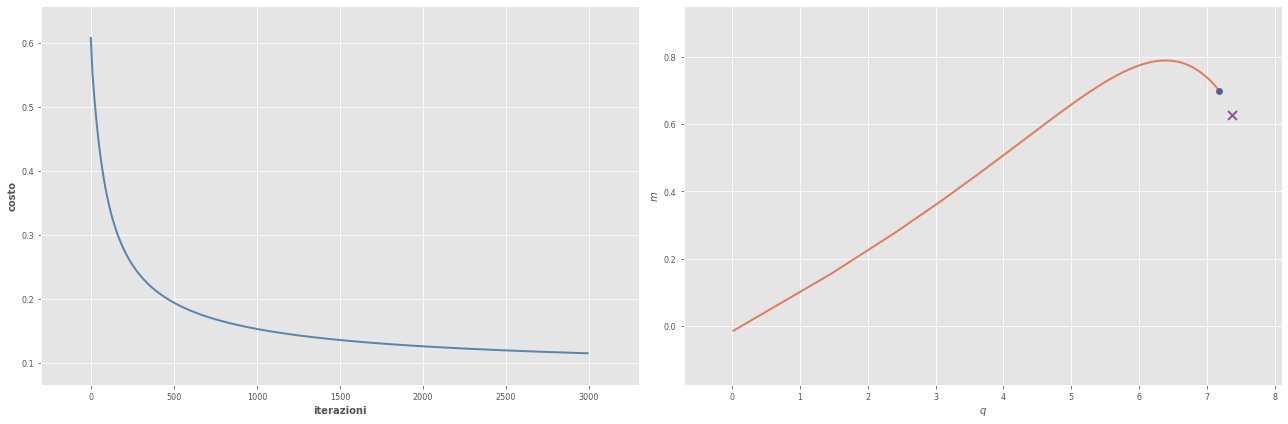

In [232]:
low, high, step = 0, 3000, 10
plot_all(cost_history_gd, m_gd, q_gd, low, high, step, m_star, q_star)

In [13]:
def plot_1(cost_history, m, q, low, high, step):
    idx = range(low,high,step)
    ch = cost_history[idx]
    th1 = m[idx]
    th0 = q[idx]
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    minx, maxx, miny, maxy = 0, len(ch), ch.min(), ch.max()
    deltay, deltax = .1*(maxy-miny), .1*(maxx-minx)
    miny, maxy, minx, maxx = miny - deltay, maxy + deltay, minx - deltax, maxx + deltax
    ax.plot(range(len(ch)), ch, alpha=1, color=colors[0], linewidth=2)
    plt.xlabel('iterazioni')
    plt.ylabel('costo')
    plt.xlim(minx,maxx)
    plt.ylim(miny,maxy)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x*step+low)))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_2(cost_history, m, q, low, high, step):
    idx = range(low,high,step)
    ch = cost_history[idx]
    th1 = m[idx]
    th0 = q[idx]
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    minx, maxx, miny, maxy = th0.min(), th0.max(), th1.min(), th1.max()
    deltay, deltax = .1*(maxy-miny), .1*(maxx-minx)
    miny, maxy = miny - deltay, maxy + deltay
    miny, maxy, minx, maxx = miny - deltay, maxy + deltay, minx - deltax, maxx + deltax
    ax.plot(th0, th1, alpha=1, color=colors[1], linewidth=2, zorder=1)
    ax.scatter(th0[-1],th1[-1], color=colors[5], marker='o', s=40, zorder=2)
    plt.xlabel(r'$m$')
    plt.ylabel(r'$q$')
    plt.xlim(minx,maxx)
    plt.ylim(miny,maxy)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

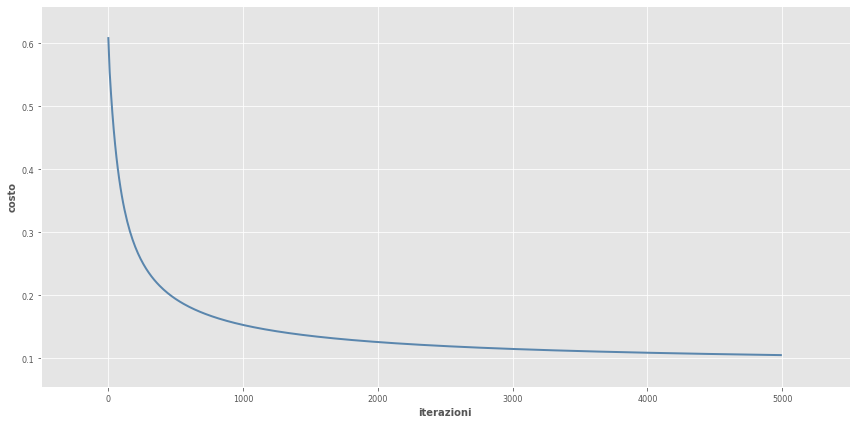

In [48]:
plot_1(cost_history_gd, m_gd, q_gd, low, high, step)

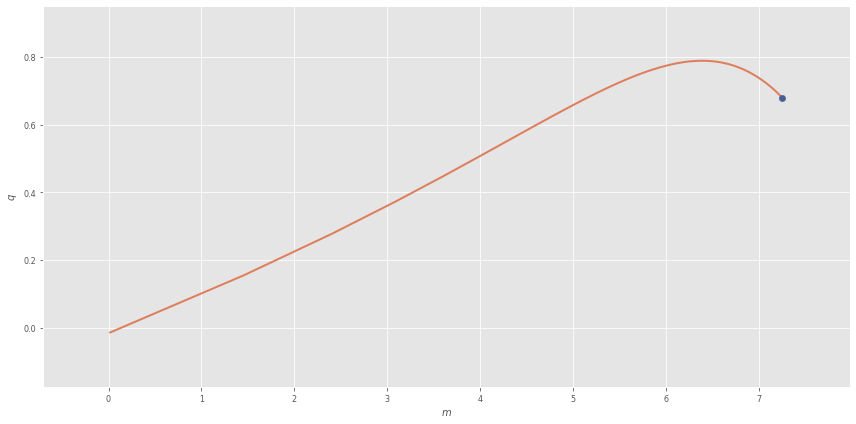

In [49]:
plot_2(cost_history_gd, m_gd, q_gd, low, high, step)

In [211]:
m_star = 0.62595499
q_star = 7.3662299

In [200]:
def f(i,m,q):
    return np.sqrt((m_star-m[i])**2+(q_star-q[i])**2)

def first_near(m, q, threshold):
    dist = np.array([f(i,m,q) for i in range(len(m))])
    md = np.ma.masked_greater_equal(dist, threshold)
    return np.ma.flatnotmasked_edges(md)[0]

In [201]:
thr=1e-3
first_near(m_gd, q_gd, thr)


76383

Di seguito, la retta di separazione risultante:

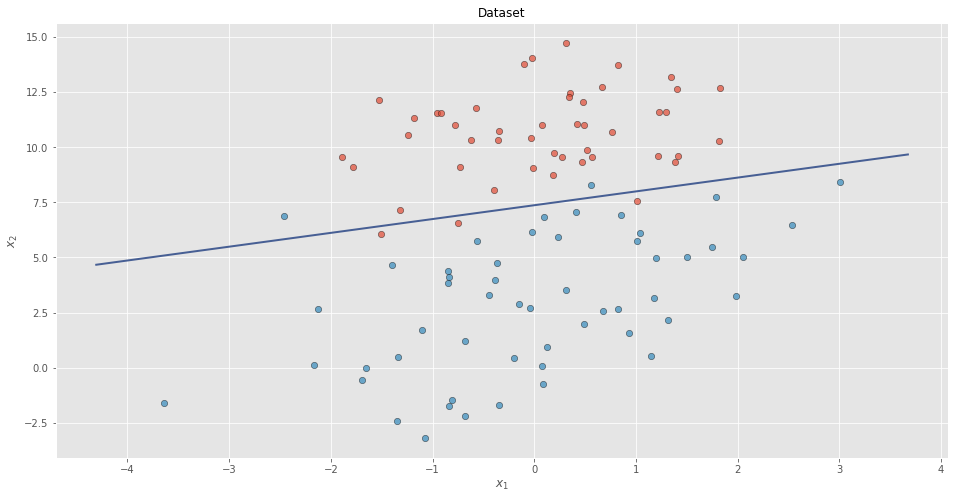

In [50]:
plot_ds(data,m_gd[-1],q_gd[-1])

#### Stochastic gradient descent

Nella stochastic gradient descent, a differenza del caso precedente, la valutazione del gradiente effettuata ad ogni iterazione fa riferimento a un solo elemento $x_i$ del training set. Quindi si ha 

$$
\theta^{(k+1)}=\theta^{(k)}-\eta J'(\theta^{(k)};x_i)
$$

e, per i singoli coefficienti,

$$
\theta_j^{(k+1)}=\theta_j^{(k)}-\eta\frac{\partial J(\theta;x_i)}{\partial\theta_j}\LARGE\vert_{\small\theta=\theta^{(k)}}
$$




La discesa del gradiente batch valuta il gradiente per tutti gli elementi, anche quelli simili tra loro, a ogni iterazione,
eseguendo così un insieme ridondante di operazioni. SGD risolve questo problema effettuando una sola valutazione, e quindi
operando in modo più veloce.

Al tempo stesso, però, mentre i valori della funzione di costo nel caso di BGD decrescono con regolarità verso il minimo locale,
applicando SGD si riscontra un andamento molto più irregolare, con fluttuazione della funzione di costo intorno a un trend
complessivo di decrescita, ma con incrementi locali anche significativi. Questo da un lato può non risultare negativo, in quanto
le oscillazioni locali posso consentire di uscire dall'intorno di un minimo locale, proseguendo la ricerca di nuovi minimi. Al
tempo stesso, l'oscillazione locale rende difficile la convergenza finale verso il minimo.

Questa oscillazione si riscontra anche nell'andamento dei valori dei coefficienti. Si noti comunque che, considerando la sequenza dei valori della funzione di costo assunti al termine di ogni *epoca* (sequenza
delle iterazioni che considerano tutti gli elementi del dataset), emerge la tendenza di decrescita di fondo. 


In termini di codice, il metodo stochastic gradient descent si presenta come:

```python
for i in range(n_epochs):
    np.random.shuffle(data)
    for k in range(dataset_size):
        g = evaluate_gradient(loss_function, theta, X[k])
        theta = theta-eta*g
```


Nel caso della logistic regression, l'aggiornamento a ogni iterazione risulta quindi
\begin{align*}
\theta_j^{(k+1)}&=\theta_j^{(k)}+\eta(t_i-\sigma(x_i))x_{ij}\hspace{1cm}j=1,\ldots,d\\
\theta_0^{(k+1)}&=\theta_0^{(k)}+\eta(t_i-\sigma(x_i))
\end{align*}

In [19]:
def stochastic_gd(X, t, eta = 0.01, epochs = 1000):
    theta = np.zeros(nfeatures+1).reshape(-1,1)
    theta_history = []
    cost_history = []
    for j in range(epochs):
        for i in range(n):
            e = (t[i] - sigma(theta, X[i,:]))[0]
            theta = theta + eta * e * X[i,:].reshape(-1,1)
            theta_history.append(theta)
            cost_history.append(cost(theta, X, t))
    theta_history = np.array(theta_history).reshape(-1,3)
    cost_history = np.array(cost_history).reshape(-1,1)
    m = -theta_history[:,1]/theta_history[:,2]
    q = -theta_history[:,0]/theta_history[:,2]
    return cost_history, theta_history, m, q

Applicando il metodo è necessario ancora specificare il valore di $\theta$ e il numero di epoche. Per la struttura dell'algoritmo, si avranno allora un numero di iterazioni pari al numero di epoche moltiplicato per la dimensionae $n$ del dataset.

In [51]:
cost_history_sgd, theta_history_sgd, m_sgd, q_sgd = stochastic_gd(X, t, eta = 0.01, epochs = 10000)

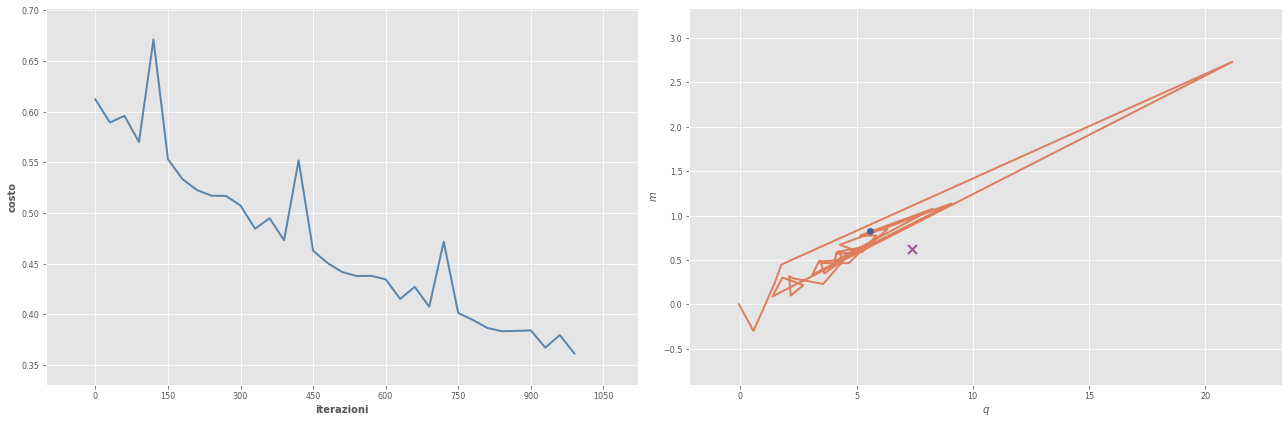

In [237]:
low, high, step = 0*n, 10*n, 30
plot_all(cost_history_sgd, m_sgd, q_sgd, low, high, step, m_star, q_star)

In [248]:
thr=1e-2
first_near(m_sgd, q_sgd, thr)

107807

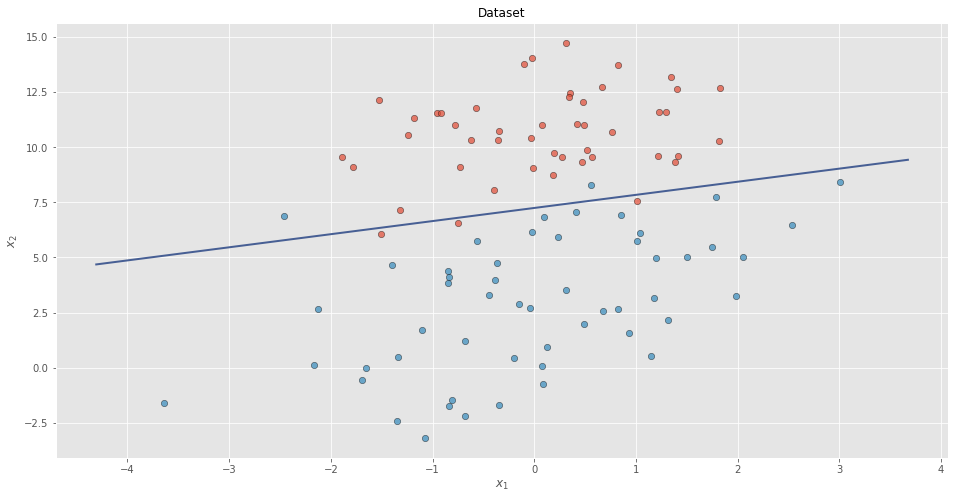

In [54]:
plot_ds(data,m_sgd[-1],q_sgd[-1])

Come si può vedere dalla figura seguente, considerando i valori di costo e dei coefficienti soltanto alla fine delle varie epoche risulta una andamento uniforme dei valori stessi.

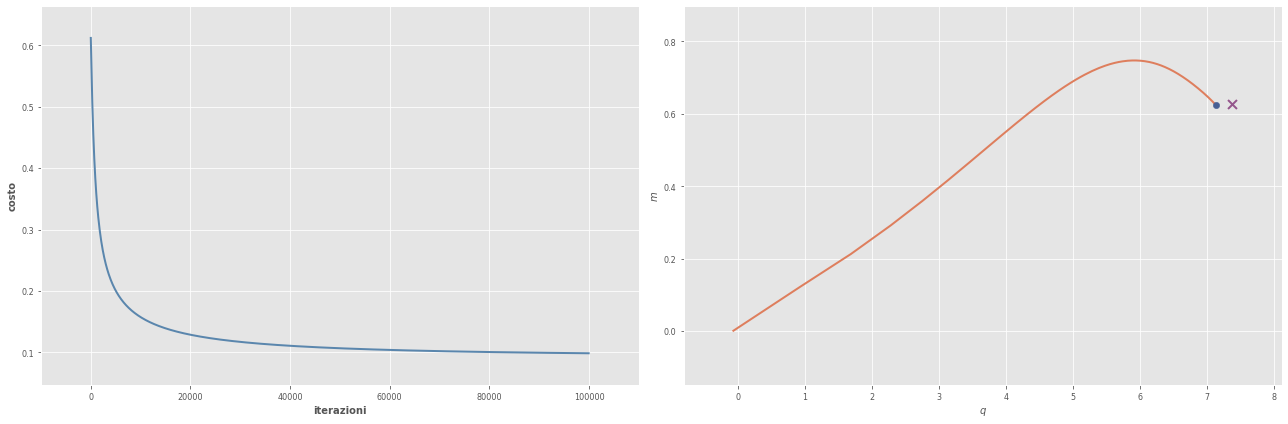

In [238]:
low, high, step = 0*n, 1000*n, n
plot_all(cost_history_sgd, m_sgd, q_sgd, low, high, step, m_star, q_star)

#### Mini-batch gradient descent

Questo approccio si pone in posizione intermedia rispetto ai due precedenti, generalizzando l'impostazione di SGD di considerare un solo elemento per iterazione a considerare sottoinsiemi diversi del dataset. L'algoritmo opera quindi partizionando, all'inizio di ogni epoca, il dataset in $\lceil n/s\rceil$ sottoinsiemi (*mini-batch*) di dimensione prefissata $s$, ed effettuando poi $\lceil n/s\rceil$ iterazioni all'interno di ognuna delle quali l'aggiornamento di $\theta$ viene effettuato valutando il gradiente sugli $s$ elementi del mini-batch attuale.

La discesa del gradiente con mini-batch è l'algoritmo tipicamente utilizzato per l'addestramento di reti neurali, in particolare in presenza di reti *deep*.

Se indichiamo con $X_i\subset X$ il mini-batch attualmente considerato, l'aggiornamento a ogni iterazione è il seguente
$$
\theta^{(k+1)}=\theta^{(k)}-\eta\sum_{x\in X_i}J'(\theta^{(k)};x)
$$
o anche
$$
\theta_j^{(k+1)}=\theta_j^{(k)}-\eta\sum_{x\in X_i}\frac{\partial J(\theta;x)}{\partial\theta_j}\LARGE\vert_{\small\theta=\theta^{(k)}}
$$
In questo modo, la varianza degli aggiornamenti dei coefficienti viene diminuita. Inoltre, è possibile fare uso, in pratica, di implementazioni molto efficienti del calcolo del gradiente rispetto a un mini-batch disponibili nelle più recenti librerie per il *deep learning*. La dimensione dei mini-batch varia tra $50$ e $256$.

```python
for i in range(n_epochs):
    np.random.shuffle(data)
    for batch in get_batches(dataset, batch_size):
        g = 0
        for x in batch:
            g = g+evaluate_gradient(loss_function, theta, batch)
        theta = theta-eta*g
```
Ne risulta un andamento oscillante sia della funzione di costo che dei valori stimati dei coefficienti. Chiaramente, l'oscillazione sarà tanto più marcata quanto minore è la dimensione dei mini-batch, e quindi quanto più si tende a SGD.

![Andamento di costo e soluzione durante l'applicazione di gradient descent con mini batch.](assets/mbgd_all.jpg)

Gli aggiornamenti nel caso della logistic regression derivano immediatamente da quanto sopra 


\begin{align*} 
\theta_j^{(k+1)}&=\theta_j^{(k)}+\eta\sum_{x_i\in MB}( t_i-y_i)x_{ij}\hspace{1cm}j=1,\ldots,d\\ 
\theta_0^{(k+1)}&=\theta_0^{(k)}+\eta\sum_{x_i\in MB}(t_i-y_i) 
\end{align*}


In [25]:
def mb_gd(X, t, eta = 0.01, epochs = 1000, minibatch_size = 5):
    mb = int(np.ceil(float(n)/minibatch_size))
    idx = np.arange(0,n)
    np.random.shuffle(idx)
    theta = np.zeros(nfeatures+1).reshape(-1,1)
    theta_history = []
    cost_history = []
    cost_history_iter = []

    for j in range(epochs):
        for k in range(mb-1):
            g = 0
            for i in idx[k*minibatch_size:(k+1)*minibatch_size]:
                e = (t[i] - sigma(theta, X[i,:]))[0]
                g = g + e * X[i,:]
            theta = theta + eta * g.reshape(-1,1)
            theta_history.append(theta)
            cost_history.append(cost(theta, X, t))
        g = 0
        for i in idx[k*minibatch_size:n]:
            e = (t[i] - sigma(theta, X[i,:]))[0]
            g = g + e * X[i,:]
        theta = theta + eta * g.reshape(-1,1)
        theta_history.append(theta)
        cost_history.append(cost(theta, X, t))
    theta_history = np.array(theta_history).reshape(-1,3)
    cost_history = np.array(cost_history).reshape(-1,1)
    m = -theta_history[:,1]/theta_history[:,2]
    q = -theta_history[:,0]/theta_history[:,2]
    return cost_history, m, q

In [251]:
cost_history_mb, m_mb, q_mb = mb_gd(X, t, eta = 0.01, epochs = 100000, minibatch_size = 8)

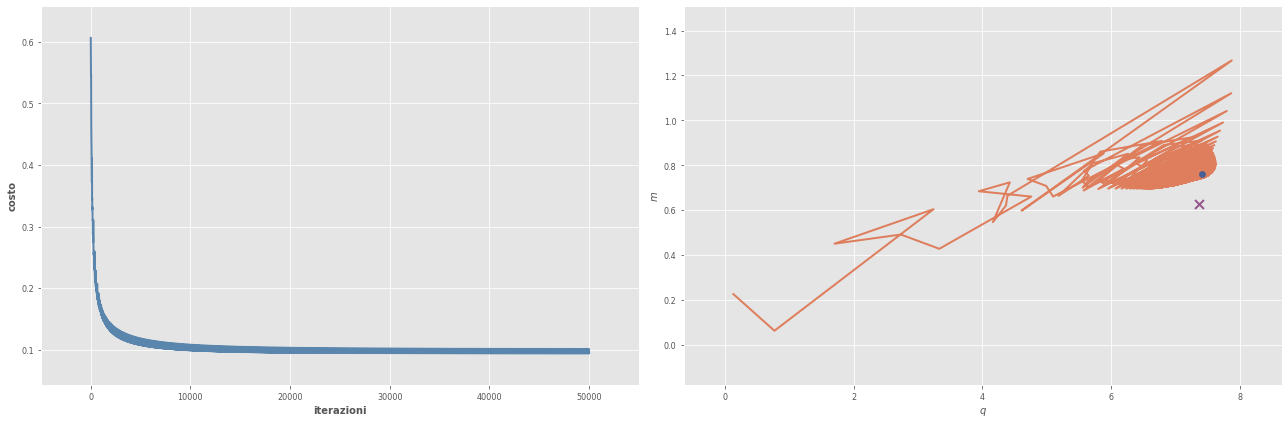

In [253]:
low, high, step = 0, 50000, 10
plot_all(cost_history_mb, m_mb, q_mb, low, high, step, m_star, q_star)

In [256]:
thr=1e-0
first_near(m_mb, q_mb, thr)

42

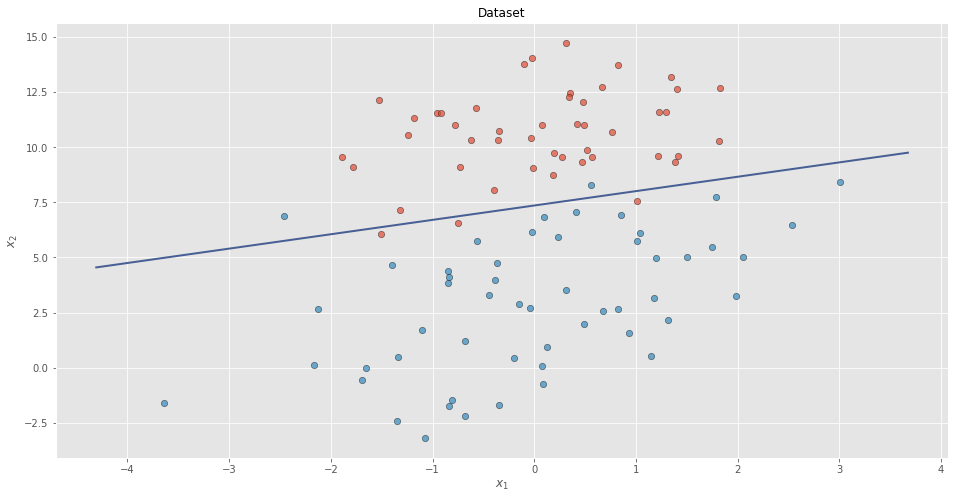

In [81]:
plot_ds(data,m_mb[-1],q_mb[-1])

#### Criticità

I metodi elementari di discesa del gradiente illustrati sopra non garantiscono in generale una elevata convergenza. Inoltre, il loro utilizzo pone un insieme di questioni

- la scelta del valore del learning rate $\eta$ può risultare difficile. Un valore troppo piccolo può comportare una convergenza eccessivamente lenta, mentre un valore troppo grande può portare ad oscillazioni intorno al minimo, o addirittura a divergenza
- per ovviare a questa problematica è possibile utilizzare dei metodi di aggiustamento di $\eta$ nel tempo, ad esempio riducendolo secondo uno schema predefinito o quando il decremento della funzione di costo calcolata in due epoche successive risulti inferiore a una soglia data. Sia gli schemi che le soglie devono però essere predefiniti e non possono quindi adattarsi in dipendenza delle caratteristiche del dataset
- lo stesso learning rate si applica per l'aggiornamento di tutti i coefficienti
- in molti casi la funzione di costo, in particolare se si ha a che fare con reti neurali, risulta fortemente non convessa, caratterizzata quindi da numerosi minimi locali e da punti di sella. I metodi considerati possono avere difficoltà a uscire da situazioni di questo tipo, e in particolare dai punti di sella, spesso circondati da regioni a gradiente molto limitato.


#### Momento

I metodi precedenti risultano poco efficienti in situazioni in cui la funzione di costo varia in modo molto diverso al variare della direzione considerata (ad esempio se si hanno valli che discendono lentamente e con pareti laterali ripide). In questo caso, infatti, gli algoritmi precedenti procedono molto lentamente in direzione del minimo, oscillando in modo sostanziale nella direzione trasversale ad essa: questa situazione è illustrata a sinistra nella figura sottostante.

Il *metodo del momento* fa riferimento ad una interpretazione fisica del metodo di ottimizzazione, in cui il processo di discesa del gradiente viene visto come lo spostamento di un corpo di massa $m=1$ che si muove sulla superficie della funzione di costo $J(\theta)$ soggetto a una forza peso $F(\theta)=-\nabla U(\theta)$, dove $U(\theta)=\eta h(\theta)=\eta J(\theta)$ è l'energia potenziale del corpo nella posizione $\theta$ (si assume quindi che la costante fisica $g$ relativa alla forza peso $F=-mgh$ sia pari a $\eta$). In questo modello, il valore negativo del gradiente $-\eta J'(\theta)$ è quindi pari al vettore forza (e accelerazione, in quanto $a=\frac{F}{m}$) del corpo nel punto $\theta$. 

Nel metodo della discesa del gradiente, si assume che lo spostamento del corpo in un certo punto $\theta$ sia determinato dalla accelerazione calcolata nello stesso punto, e quindi dal gradiente $J'(\theta)$, in quanto vale la regola di aggiornamento $\theta^{(k+1)}=\theta^{(k)}-\eta J'(\theta^{(k)})$. 

Nel metodo del momento, si fa riferimento a un modello più consistente con la realtà fisica di un corpo che si muove su una superficie soggetto alla forza peso, modello che prevede di utilizzare il concetto di velocità $v(\theta)$. In questo modello, lo spostamento del corpo a partire da un certo punto $\theta$ è determinato dalla velocità calcolata nello stesso punto $\theta^{(k+1)}=\theta^{(k)}+v^{(k+1)}$, dove la variazione di velocità è data dalla accelerazione $v^{(k+1)}=v^{(k)}-\eta J'(\theta^{(k)})$. 

Come si può osservare, si ha che

\begin{align*}
v^{(k+1)}&=-\eta J'(\theta^{(k)})+v^{(k)}=-\eta J'(\theta^{(k)})-\eta J'(\theta^{(k-1)})+v^{(k-1)}=\cdots=-\eta\sum_{i=0}^kJ'(\theta^{(i)})+v^{(0)}\\
\theta^{(k+1)}&=\theta^{(k)}+v^{(k+1)}=\theta^{(k)}-\eta\sum_{i=0}^kJ'(\theta^{(i)})+v^{(0)}
\end{align*}

che corrisponde all'associare lo spostamento alla somma (integrale nel caso della fisica) delle accelerazioni passate.


 
![Effetto dell'introduzione di momento nell'andamento del costo durante l'applicazione di gradient descent.](assets/momentum.jpg)

Il riferimento a questo modello porta l'algoritmo a tendere ad ogni passo a mantenere, almeno in parte, la direzione del passo precedente (in quanto $v^{(k+1)}=-\eta J'(\theta^{(k)})+v^{(k)})$, premiando le direzioni che si manifestano con costanza in una sequenza di passi. Ne deriva il comportamento a destra della figura precedente, in cui l'inerzia nella direzione del minimo porta a una limitazione delle oscillazioni.

Si noti che ciò non avviene nella  discesa del gradiente, in cui si ha $v^{(k+1)}=-\eta J'(\theta^{(k)})$.

Matematicamente, l'effetto di inerzia viene ottenuto sottraendo alla velocità (vettoriale) calcolata al passo precedente la valutazione del gradiente effettuata nella corrispondente posizione. Il gradiente viene sottratto in quanto, mantenendo la corrispondenza con la meccanica di , un gradiente positivo tende a ridurre la velocità.

Il metodo del momento utilizza tipicamente un secondo parametro $\gamma$, che determina la frazione di $v^{(k)}$ che permane nella definizione di $v^{(k+1)}$, e che svolge la funzione (fisicamente) di un coefficiente di attrito. Si ottiene quindi la formulazione:

\begin{align*}
v^{(k+1)}&=\gamma v^{(k)} -\eta\sum_{i=1}^nJ'(\theta^{(k)};x_i)\\
\theta^{(k+1)}&=\theta^{(k)}+v^{(k+1)}
\end{align*}
Il metodo del momento ad ogni passo determina inizialmente il vettore di spostamento attuale, a partire da quello al passo precedente e dal gradiente di $\theta$: il contributo relativo dei due termini è pesato dalla coppia di parametri $\gamma$ e $\eta$. Lo spostamento calcolato viene quindi applicato al valore attuale di $\theta$ (il segno meno deriva come sempre dal fatto che stiamo assumendo di cercare un minimo locale).

Se il gradiente è orientato nella stessa direzione della velocità attuale, tale velocità viene incrementata, per cui l'aggiornamento di $\theta$ diviene maggiore, incrementandosi man mano che la direzione di spostamento rimane coerente con il gradiente nei punti attraversati.

```python
v = 0
for i in range(n_epochs):
    g = 0
    for k in range(dataset_size):
        g = g+evaluate_gradient(loss_function, theta, X[k])
    v = gamma*v-eta*g
    theta = theta+v
```


Come si può vedere, mentre $\theta^{(k)}=(\theta_1^{(k)},\ldots,\theta_d^{(k)})^T$ è la valutazione della soluzione ottima al passo $k$, $v^{(k)}=(v_1^{(k)},\ldots,v_d^{(k)})^T$ è l'aggiornamento applicato a tale valore per ottenere $\theta^{(k+1)}$: possiamo vedere quindi $v$ come il vettore velocità di spostamento di $\theta$ nello spazio delle soluzioni.

Come già illustrato sopra, possiamo esprimere l'aggiornamento nel modo seguente, evidenziando come esso dipenda dal gradiente calcolato in tutte le posizioni precedentemente attraversate, con un effetto che va a diminuire esponenzialmente con $\gamma$ man mano che si risale nel passato. Assumendo $v^{(0)}=0$:

\begin{align*}
\theta^{(k+1)}&=\theta^{(k+1)}+v^{(k+1)}= \theta^{(k)}+\gamma v^{(k)}-\eta\sum_{i=1}^nJ'(\theta^{(k)};x_i)=\theta^{(k)}+\gamma^2 v^{(k-1)}-\gamma\eta\sum_{i=1}^nJ'(\theta^{(k-1)};x_i) -\eta\sum_{i=1}^nJ'(\theta^{(k)};x_i)\\
&=\theta^{(k)}+\gamma^2 v^{(k-1)}-\eta\left(\sum_{i=1}^nJ'(\theta^{(k)};x_i)+\gamma\sum_{i=1}^nJ'(\theta^{(k-1)};x_i)\right)=\cdots=
\theta^{(k)}-\eta\left(\sum_{j=0}^k\gamma^j\sum_{i=1}^nJ'(\theta^{(k-j)};x_i)\right)
\end{align*}

Gli aggiornamenti nel caso della logistic regression derivano immediatamente

\begin{align*} 
v_j^{(k+1)}&=\gamma v_j^{(k)}+\frac{\eta}{n}\sum_{i=1}^n( t_i-\sigma(x_i))x_{ij}\hspace{1cm}j=1,\ldots,d\\ 
v_0^{(k+1)}&=\gamma v_0^{(k)}+\frac{\eta}{n}\sum_{i=1}^n(t_i-\sigma(x_i)) \\
\theta_j^{(k+1)}&=\theta_j^{(k)}+v_j^{(k+1)}\hspace{1cm}j=0,\ldots,d
\end{align*}

In [82]:
def momentum_gd(X,t, eta = 0.1, gamma = 0.97, epochs = 1000):
    theta = np.zeros(nfeatures+1).reshape(-1,1)
    v = np.zeros(nfeatures+1).reshape(-1,1)
    theta_history = []
    cost_history = []
    for k in range(epochs):           
        v = gamma*v - eta * gradient(theta,X,t)
        theta = theta + v
        theta_history.append(theta)
        cost_history.append(cost(theta, X, t))
    theta_history = np.array(theta_history).reshape(-1,3)
    cost_history = np.array(cost_history).reshape(-1,1)
    m = -theta_history[:,1]/theta_history[:,2]
    q = -theta_history[:,0]/theta_history[:,2]
    return cost_history, m, q

In [168]:
cost_history_mgd, m_mgd, q_mgd = momentum_gd(X, t, eta = 0.1, gamma = 0.97, epochs = 10000)

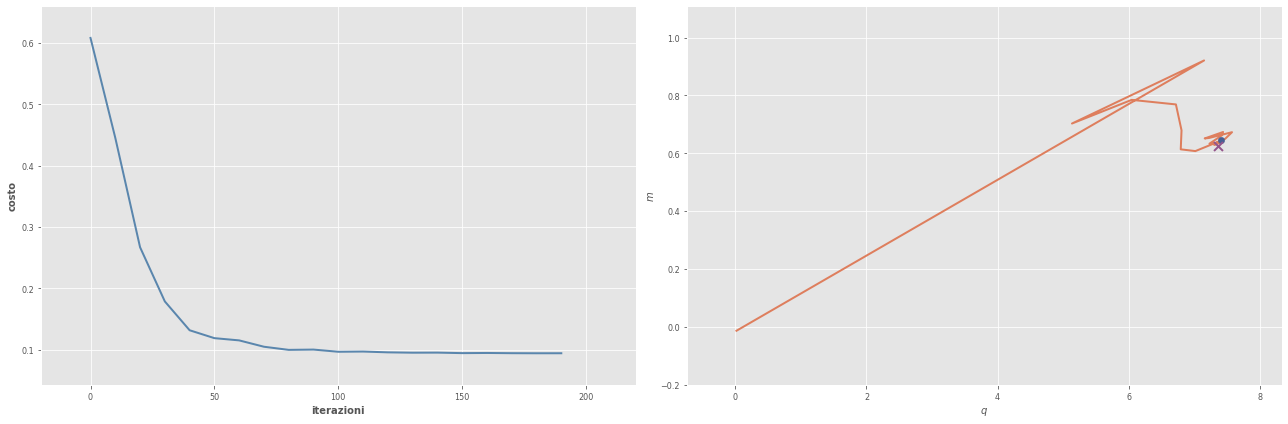

In [246]:
low, high, step = 0, 200, 10
plot_all(cost_history_mgd, m_mgd, q_mgd, low, high, step, m_star, q_star)

In [187]:
def first_near(dist, m, q):
    dist = np.array([f(i,m,q) for i in range(len(m))])
    md = np.ma.masked_greater_equal(dist, threshold)
    return np.ma.flatnotmasked_edges(md)[0]


In [258]:
thr=1e-3
first_near(m_mgd, q_mgd, thr)

1515

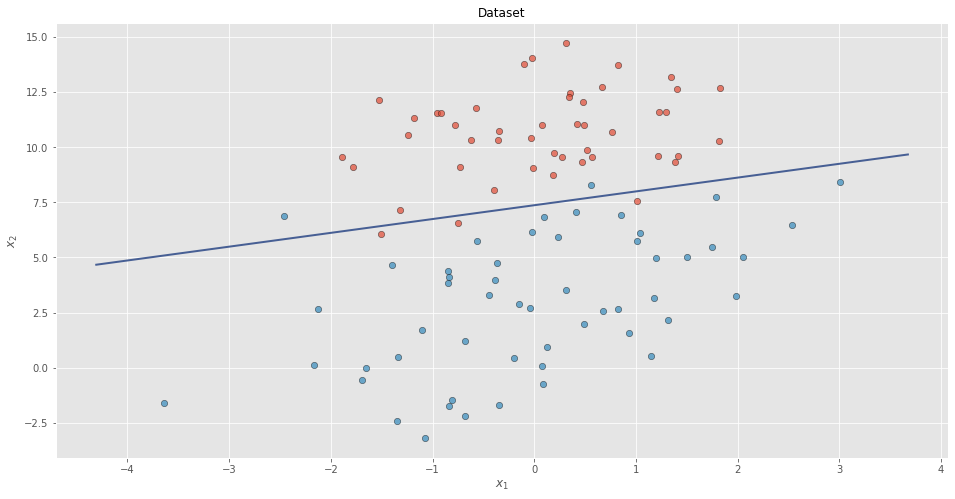

In [89]:
plot_ds(data,m_mgd[-1],q_mgd[-1])

#### Accelerazione del gradiente di Nesterov
Nel metodo del momento, la conoscenza al passo $k$ di $\theta^{(k)}$ e di $v^{(k)}$ permette, senza calcolare il gradiente, di avere una valutazione approssimata $\tilde{\theta}^{(k+1)}=\theta^{(k)}+\gamma v^{(k)}$ di 
$$
\theta^{(k+1)}=\theta^{(k)}+v^{(k+1)}=\theta^{(k)}+\gamma v^{(k)}-\eta\sum_{i=1}^nJ'(\theta^{(k)};x_i)=\tilde{\theta}^{(k+1)}-\eta\sum_{i=1}^nJ'(\theta^{(k)};x_i)
$$
Il metodo di Nesterov segue lo stesso approccio del metodo del momento, con la differenza che, ad ogni passo, la valutazione del gradiente viene effettuata, con un *look-ahead* approssimato, non nel punto attuale $\theta^{(k)}$ dello spazio delle soluzioni visitato ma, più o meno, nel punto successivo $\theta^{(k+1)}$ (approssimato da $\tilde{\theta}^{(k+1)}$). In questo modo, le variazioni di $v$ (e quindi di $\theta$) vengono anticipate rispetto a quanto avviene nel metodo del momento.
\begin{align*}
v^{(k+1)}&=\gamma v^{(k)} +\eta\sum_{i=1}^nJ'(\tilde{\theta}^{(k)};x_i)=\gamma v^{(k)} +\eta\sum_{i=1}^nJ'(\theta^{(k)}+\gamma v^{(k)};x_i)\\
\theta^{(k+1)}&=\theta^{(k)}+v^{(k+1)}
\end{align*}

![Aggiornamento per momentum e per Nesterov.](assets/nesterov.png)




```python
v = 0
for i in range(n_epochs):
    g = 0
    theta_approx = theta+gamma*v
    for k in range(dataset_size):
        g = g+evaluate_gradient(loss_function, theta_approx, X[k])
    v = gamma*v-eta*g
    theta = theta+v
```

In [91]:
def nesterov_gd(X,t, eta = 0.1, gamma = 0.97, epochs = 1000):
    theta = np.zeros(nfeatures+1).reshape(-1,1)
    v = np.zeros(nfeatures+1).reshape(-1,1)
    theta_history = []
    cost_history = []
    for k in range(epochs):           
        v = gamma*v - eta * gradient(theta+gamma*v,X,t)
        theta = theta + v
        theta_history.append(theta)
        cost_history.append(cost(theta, X, t))
    theta_history = np.array(theta_history).reshape(-1,3)
    cost_history = np.array(cost_history).reshape(-1,1)
    m = -theta_history[:,1]/theta_history[:,2]
    q = -theta_history[:,0]/theta_history[:,2]
    return cost_history, m, q

In [92]:
cost_history_ngd, m_ngd, q_ngd = nesterov_gd(X, t, eta = 0.1, gamma = 0.97, epochs = 10000)

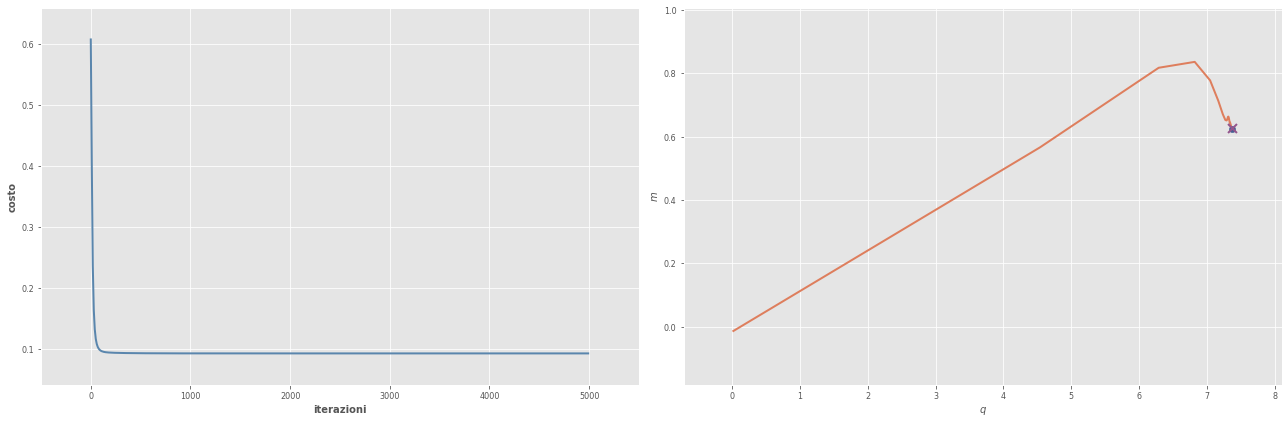

In [260]:
low, high, step = 0, 5000, 10
plot_all(cost_history_ngd, m_ngd, q_ngd, low, high, step, m_star, q_star)

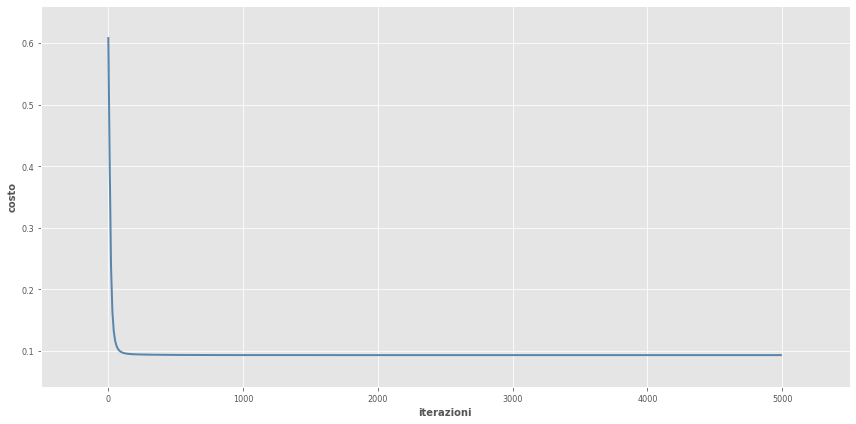

In [94]:
plot_1(cost_history_ngd, m_ngd, q_ngd, low, high, step)

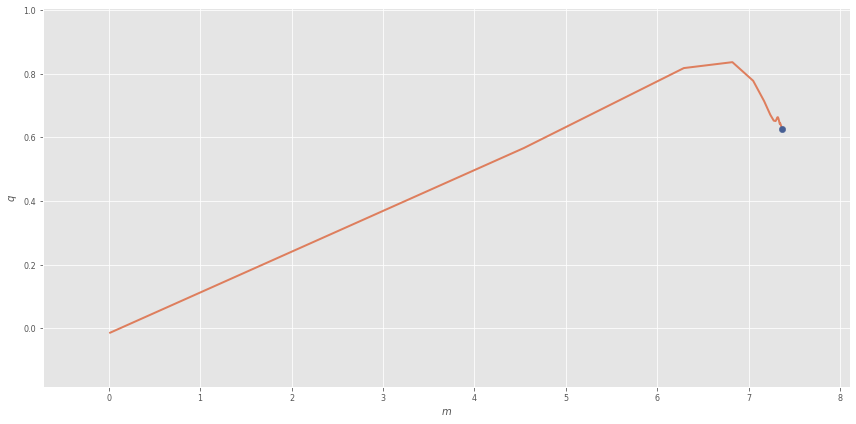

In [95]:
plot_2(cost_history_ngd, m_ngd, q_ngd, low, high, step)

In [96]:
def plot_11(cost_history_1, cost_history_2, low, high, step):
    idx = range(low,high,step)
    ch_1 = cost_history_1[idx]
    ch_2 = cost_history_2[idx]
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    minx, maxx, miny, maxy = 0, len(ch_1), ch_1.min(), ch_1.max()
    deltay, deltax = .1*(maxy-miny), .1*(maxx-minx)
    miny, maxy, minx, maxx = miny - deltay, maxy + deltay, minx - deltax, maxx + deltax
    ax.plot(range(len(ch_1)), ch_1, alpha=1, color=colors[0], linewidth=2)
    ax.plot(range(len(ch_2)), ch_2, alpha=1, color=colors[3], linewidth=2)
    plt.xlabel('iterazioni')
    plt.ylabel('costo')
    plt.xlim(minx,maxx)
    plt.ylim(miny,maxy)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x*step+low)))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_22(m_1, q_1, m_2, q_2, low, high, step, l1, l2):
    idx = range(low,high,step)
    th1_1 = m_1[idx]
    th0_1 = q_1[idx]
    th1_2 = m_2[idx]
    th0_2 = q_2[idx]
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    minx, maxx, miny, maxy = th0_1.min(), th0_1.max(), th1_1.min(), th1_1.max()
    deltay, deltax = .1*(maxy-miny), .1*(maxx-minx)
    miny, maxy = miny - deltay, maxy + deltay
    miny, maxy, minx, maxx = miny - deltay, maxy + deltay, minx - deltax, maxx + deltax
    ax.plot(th0_1, th1_1, alpha=1, color=colors[1], linewidth=2, zorder=1, label=l1)
    ax.scatter(th0_1[-1],th1_1[-1], color=colors[5], marker='o', s=40, zorder=2)
    ax.plot(th0_2, th1_2, alpha=1, color=colors[2], linewidth=2, zorder=1, label=l2)
    ax.scatter(th0_2[-1],th1_2[-1], color=colors[5], marker='o', s=40, zorder=2)
    #plt.xlabel(r'$m$')
    #plt.ylabel(r'$q$')
    plt.xlim(minx,maxx)
    plt.ylim(miny,maxy)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.legend()
    plt.tight_layout()
    plt.show()

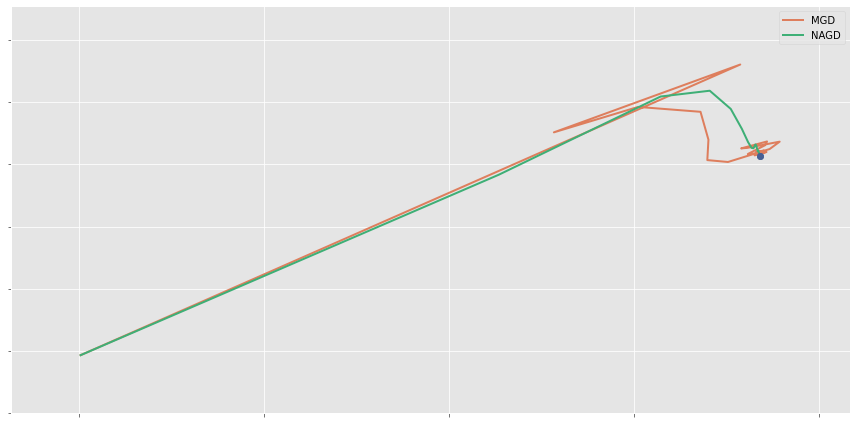

In [101]:
length = 10000
plot_22(m_mgd[:length], q_mgd[:length], m_ngd[:length], q_ngd[:length], low, high, step, 'MGD', 'NAGD')

In [261]:
thr=1e-3
first_near(m_ngd, q_ngd, thr)

1681

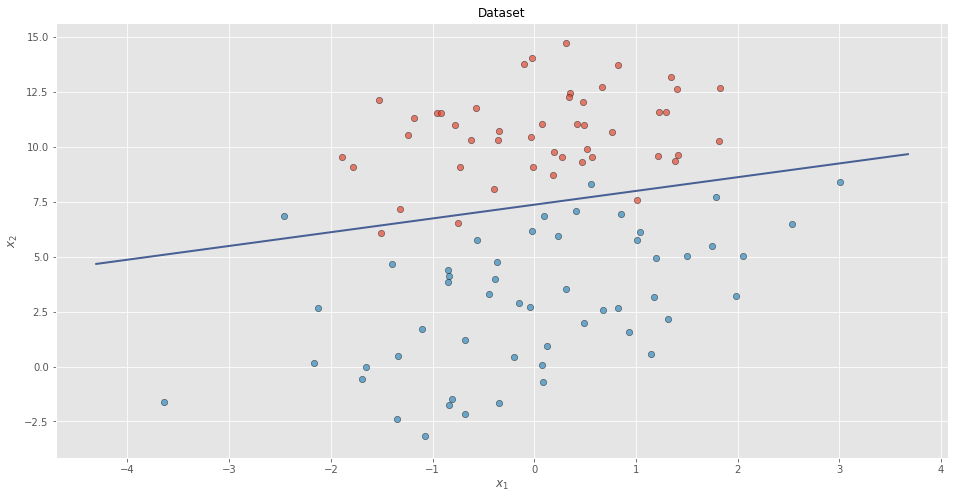

In [44]:
plot_ds(data,m[-1],q[-1])

### Adagrad

Adagrad introduce la possibilità di applicare leaarning rate diversi ai vari parametri da ottimizzare (dimensioni dello spazio di ricerca): in particolare, dimensioni rispetto alle quali si sono avuti nel corso dei passi precedenti valori elevati del gradiente avranno associati, tendenzialmente, learning rate più piccoli, in modo tale che l'aggiornamento nella direzione stessa sia limitato. Al contrario, in presenza di dimensioni (parametri) con valori del gradiente precedenti piccoli, e quindi poco modificate, il learning rate risulterà più grande, rendendo le modifiche delle componenti corrispondenti più sensibili ai valori del gradiente.

Come visto, nella gradient descent "base" l'aggiornamento del coefficiente $k$-esimo è dato da

$$
\theta_j^{(k+1)}= \theta_j^{(k)}-\eta \frac{\partial J(\theta, X)}{\partial\theta_j}\Bigr\vert_{\small\theta=\theta^{(k)}}= \theta_j^{(k)}-\eta\sum_{i=1}^n\frac{\partial J(\theta;x_i)}{\partial\theta_j}\Bigr\vert_{\small\theta=\theta^{(k)}}
$$

dove $\eta$ è lo stesso per tutti i coefficienti. In Adagrad, l'aggiornamento prevede un learning rate
$\eta_{j}^{(k)}$, dipendente dal coefficiente e dal passo di applicazione del metodo, definito nel modo seguente

$$
\eta_{j}^{(k)} = \frac{\eta}{\sqrt{G_{j,k}+\varepsilon}}
$$

dove $\eta$ è una costante, $G_{j,k}=\sum_{i=0}^{k}g_{j,i}^2$ è la somma dei valori $g_{j,i}=\frac{\partial J(\theta, X)}{\partial\theta_j}\Bigr\vert_{\small\theta=\theta^{(i)}}$ del gradiente relativo a $\theta_j$ per tutte le iterazioni precedenti, mentre $\varepsilon$ è una piccola costante di *smoothing* utilizzata per evitare denominatori nulli.

Utilizzando il formalismo introdotto, l'aggiornamento di $\theta_j$ alla $k+1$-esima iterazione è data da

$$
\theta_j^{(k+1)}= \theta_j^{(k)}-\frac{\eta}{\sqrt{G_{j,k}+\varepsilon}}g_{j,k}
$$

Come si può vedere, il learning rate diminuisce in modo monotono al procedere delle iterazioni per tutti i coefficienti. Al tempo stesso, coefficienti con elevati valori di gradiente nel passato (quindi soggetti a variazioni significative) avranno decrementi più elevati del learning rate, che quindi tenderà più rapidamente a $0$ e a modificare poco i valori di tali cofficienti, mentre coefficienti con valori limitati (che sono variati poco fino ad ora) manterrano un learning rate più alto.

Dato che in ogni caso il denominatore cresce ad ogni iterazione, il learning rate continua a diminuire fino a raggiungere valori talmente piccoli da impedire un reale aggiornamento della soluzione.

In [146]:
def adagrad(X,t, eta = 0.01, epsilon = 0.0000001, epochs = 1000):
    theta = np.zeros(nfeatures+1).reshape(-1,1)
    G = np.zeros(nfeatures+1).reshape(-1,1)
    theta_history = []
    cost_history = []
    for k in range(epochs):   
        g = gradient(theta,X,t)
        G = G + g**2
        denoms = np.sqrt(G+epsilon)
        theta = theta - eta/denoms*g
        theta_history.append(theta)
        cost_history.append(cost(theta, X, t))
    theta_history = np.array(theta_history).reshape(-1,3)
    cost_history = np.array(cost_history).reshape(-1,1)
    m = -theta_history[:,1]/theta_history[:,2]
    q = -theta_history[:,0]/theta_history[:,2]
    return cost_history, m, q

In [153]:
cost_history_ag, m_ag, q_ag = adagrad(X, t, eta = 0.01, epsilon = 0.0000001, epochs = 100000)

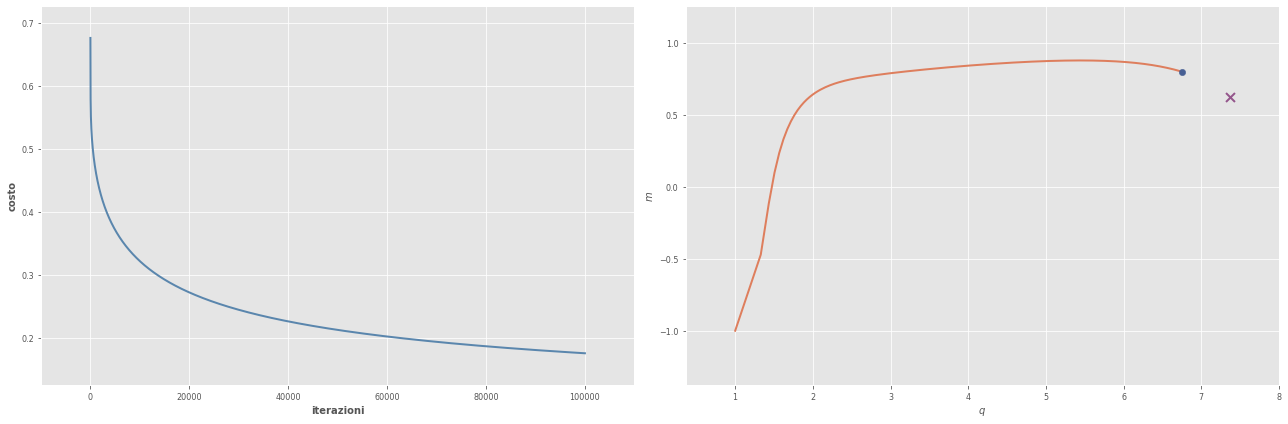

In [264]:
low, high, step = 0, 100000, 10
plot_all(cost_history_ag, m_ag, q_ag, low, high, step, m_star, q_star)

In [1]:
thr=1e-2
first_near(m_ag, q_ag, thr)


NameError: name 'first_near' is not defined

### Adadelta

Al fine di limitare una eccessiva diminuzione del learning rate, in Adadelta non vengono accumulati tutti i gradienti passati attraverso la somma dei loro quadrati, per cui si ha: 

$$
G_{j,k}=G_{j,k-1}+g_{j,k}^2
$$

viene invece applicato uno *smorzamento* (decay) per mezzo di un coefficiente $0<\gamma<1$

$$
G_{j,k}=\gamma G_{j,k-1}+(1-\gamma)g_{j,k}^2
$$


### Metodi del secondo ordine

La ricerca di un punto di massimo (o minimo) può anche essere effettuata in termini di ricerca di punti in cui la derivata prima (o il gradiente, in generale) si annullano, applicando uno dei metodi iterativi standard per la ricerca degli zeri di una funzione.

Un tipico metodo utilizzato in questo ambito è quello di Newton-Raphson, in cui (considerando una funzione univariata) viene applicato, ad ogni iterazione, l'aggiornamento

$$
x_{i+1}=x_{i}-\frac{f(x_{i})}{f'(x_{i})}
$$

A ogni iterazione, l'algoritmo approssima $f$ per mezzo di una retta tangente a $f$ in $(x_i,f(x_{i}))$, e definisce $x_{i+1}$ come il valore in cui tale retta interseca l'asse $x$.

![Newton-Raphson.](assets/newton.pdf)


Nel caso in cui si cercano punti di massimo o minimo, l'iterazione evidentemente diviene

$$
x_{i+1}=x_{i}-\frac{f'(x_{i})}{f''(x_{i})}
$$

Nel caso di funzioni a più variabili, la derivata prima è sostituita dal gradiente 
$\nabla f$, mentre la derivata seconda corrisponde alla matrice *Hessiana* $H$, definita come

$$
H_{ij}(f)=\frac{\partial^{2}f}{\partial x_{i}\partial x_{j}}
$$

L'aggiornamento ad ogni iterazione diviene quindi

$$
x^{(i+1)}=x^{(i)}-\big(H(f)^{-1}\nabla f\big)\big|_{ x_{(i)}}
$$
